In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
#Se importa la Base de datos a un data frame
file_path = '/content/drive/MyDrive/Inv. teórica/Base de Datos/soc-redditHyperlinks-title.tsv'
df = pd.read_csv(file_path, delimiter='\t')

In [ ]:
# Crear un grafo dirigido
G = nx.DiGraph()

# Iterar a través del DataFrame para añadir nodos y enlaces
for index, row in df.iterrows():
    source = row['SOURCE_SUBREDDIT']
    target = row['TARGET_SUBREDDIT']
    post_label = row['LINK_SENTIMENT']
    post_properties = list(map(float, row['PROPERTIES'].split(',')))

    # Añadir nodos
    if not G.has_node(source):
        G.add_node(source)
    if not G.has_node(target):
        G.add_node(target)

    # Añadir un enlace dirigido del subreddit fuente al subreddit objetivo
    G.add_edge(source, target, post_label=post_label, post_properties=post_properties)

In [ ]:
len(G)

54075

# Exploración de la red general

Distribución de Grado de entrada y salida

In [ ]:
# Calcular el grado de entrada y el grado de salida para cada nodo
in_degrees = dict(G.in_degree())  # Grado de entrada
out_degrees = dict(G.out_degree())  # Grado de salida

# Extraer los valores de grado para el análisis
in_degree_values = list(in_degrees.values())
out_degree_values = list(out_degrees.values())

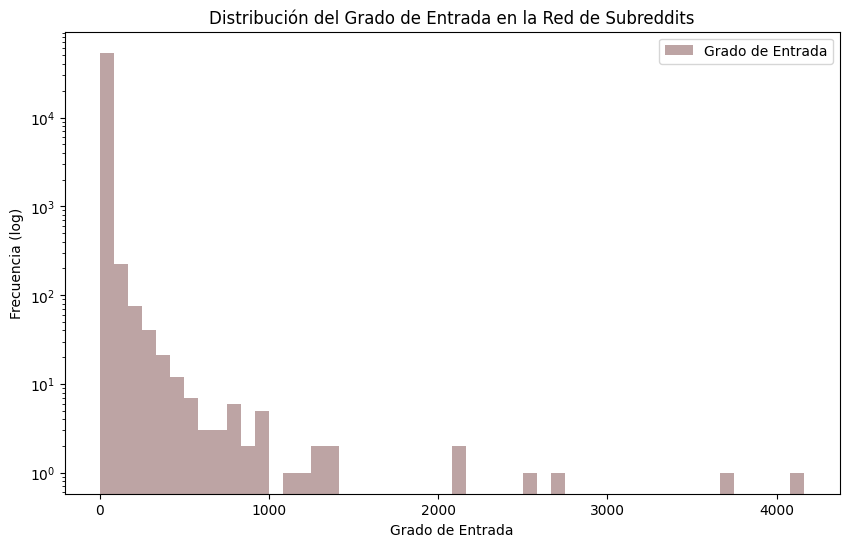

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(in_degree_values, bins=50, log=True, alpha=0.5, color='#7D4A4B', label='Grado de Entrada')  # Usamos escala logarítmica
plt.title('Distribución del Grado de Entrada en la Red de Subreddits')
plt.xlabel('Grado de Entrada')
plt.ylabel('Frecuencia (log)')
plt.legend()
plt.savefig('Distribución de grado entrada general.jpg')

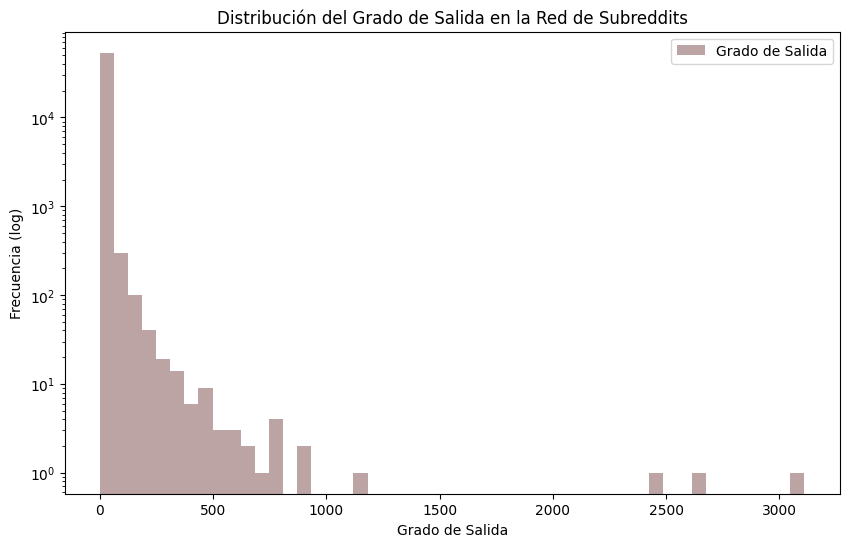

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(out_degree_values, bins=50, log=True, alpha=0.5, color='#7D4A4B', label='Grado de Salida')  # Usamos escala logarítmica
plt.title('Distribución del Grado de Salida en la Red de Subreddits')
plt.xlabel('Grado de Salida')
plt.ylabel('Frecuencia (log)')
plt.legend()
plt.savefig('Distribución de grado salida general.jpg')

La distribución tiene una forma de cola larga (long-tail), lo cual es típico de muchas redes sociales y naturales. Esto significa que la mayoría de los subreddits tienen un grado de salida relativamente bajo (hacen referencia a unos pocos otros subreddits), mientras que hay unos pocos subreddits con un grado de salida muy alto (hacen referencia a muchos otros subreddits).

Los nodos con un alto grado de salida pueden ser considerados como influenciadores o puntos de difusión clave, ya que enlazan a muchos otros subreddits. Estos subreddits podrían jugar un papel importante en la propagación de información e ideologías.

La naturaleza de la cola larga sugiere que la distribución podría ajustarse a una ley de potencia, lo que es común en las redes de escala libre. Esto implica que hay mecanismos de crecimiento de red como el "attachment preferencial", donde los nuevos enlaces tienen una mayor probabilidad de conectarse a nodos ya bien conectados.

Los subreddits con grados de salida medios a altos podrían ser lugares estratégicos para el monitoreo o la intervención de la difusión de información, especialmente si están relacionados con la política o ideologías específicas.

Las redes con esta distribución de grado son generalmente robustas a la eliminación aleatoria de nodos pero pueden ser vulnerables a ataques dirigidos (es decir, la eliminación de los nodos más conectados).



In [ ]:
density = nx.density(G)
print(f'Densidad de la red: {density}')

Densidad de la red: 8.029680598483293e-05


In [ ]:
# Convertir a grafo no dirigido
G_undirected = G.to_undirected()

# Encontrar todas las componentes conexas
connected_components = list(nx.connected_components(G_undirected))

# Contar el número de componentes conexas
num_connected_components = len(connected_components)
print(f'Número de componentes conexas: {num_connected_components}')

Número de componentes conexas: 758


hay 758 grupos aislados de subreddits en los que cada grupo está interconectado internamente, pero no hay enlaces entre los grupos.

In [ ]:
# Encontrar la componente gigante
largest_component = max(connected_components, key=len)

# Crear un subgrafo que contiene solo los nodos de la componente gigante
subgraph_giant_component = G_undirected.subgraph(largest_component)

# Analizar la componente gigante
num_nodes_giant = subgraph_giant_component.number_of_nodes()
num_edges_giant = subgraph_giant_component.number_of_edges()
density_giant = nx.density(subgraph_giant_component)

print(f'Número de nodos en la componente gigante: {num_nodes_giant}')
#print(f'Número de enlaces en la componente gigante: {num_edges_giant}')
print(f'Densidad de la componente gigante: {density_giant}')

Número de nodos en la componente gigante: 52468
Densidad de la componente gigante: 0.00015932354588831906


La gran mayoría de los subreddits (52,468 de 54,075) están en la componente gigante. Esto implica que casi todos los subreddits están de alguna manera interconectados, aunque sea indirectamente, y podrían influenciarse entre sí a través de una cadena de enlaces.




Esto nos dice que la difusión de información probablemente depende de rutas específicas a través de ciertos nodos clave o influyentes, en lugar de una difusión uniforme a través de la red. Y esto es lo que queremos explorar en nuestro proyecto.

------------------------------

In [ ]:
num_components = nx.number_weakly_connected_components(G)
print(f"Número de componentes débilmente conectadas: {num_components}")


Número de componentes débilmente conectadas: 758


In [ ]:
weakly_connected_components = list(nx.weakly_connected_components(G))
component_sizes = [len(component) for component in weakly_connected_components]
component_sizes.sort(reverse=True)  # Ordenar de mayor a menor

print(f"Las 5 componentes más grandes tienen estos tamaños: {component_sizes[:5]}")


Las 5 componentes más grandes tienen estos tamaños: [52468, 8, 7, 6, 6]


In [ ]:
# Encontrar la componente gigante débilmente conectada (Weakly Connected Component)
largest_weakly_connected_component = max(nx.weakly_connected_components(G), key=len)

# Verificar el número de nodos en esta componente antes de crear el subgrafo
print(f"Número de nodos en largest_weakly_connected_component: {len(largest_weakly_connected_component)}")


Número de nodos en largest_weakly_connected_component: 52468


In [ ]:
# Crear un subgrafo a partir de la componente gigante débilmente conectada
G1 = G.subgraph(largest_weakly_connected_component).copy()

# Verificar que el subgrafo G1 tiene los mismos nodos
print(f"Número de nodos en G1: {G1.number_of_nodes()}")


Número de nodos en G1: 52468


In [ ]:
# Crear una copia de G1 con los atributos de tipo lista convertidos a cadenas
G1_copy = G1.copy()

for u, v, data in G1_copy.edges(data=True):
    # Convertir 'post_properties' de lista a cadena de texto si es una lista
    if isinstance(data.get('post_properties'), list):
        data['post_properties'] = ','.join(map(str, data['post_properties']))

# Guardar el subgrafo G1_copy en un archivo GraphML
nx.write_graphml(G1_copy,  "/content/drive/MyDrive/Inv. teórica/Base de Datos/subgraph_giant.gexf")



In [ ]:
# Asegúrate de que G1 es una copia real
G1 = G.subgraph(largest_weakly_connected_component).copy()

# Verifica si el subgrafo G1 es dirigido
print(f"G1 es dirigido: {nx.is_directed(G1)}")


G1 es dirigido: True


A partir del grafo de la componente gigante débilmente conectada, vamos a determinar la distribución de grados de entrada y de salida:

In [ ]:
# Calcular el grado de entrada y el grado de salida para cada nodo (componente gigante)
in_degrees_giant = dict(G1.in_degree())  # Grado de entrada
out_degrees_giant = dict(G1.out_degree())  # Grado de salida

# Extraer los valores de grado para el análisis
in_degree_values_giant = list(in_degrees_giant.values())
out_degree_values_giant = list(out_degrees_giant.values())

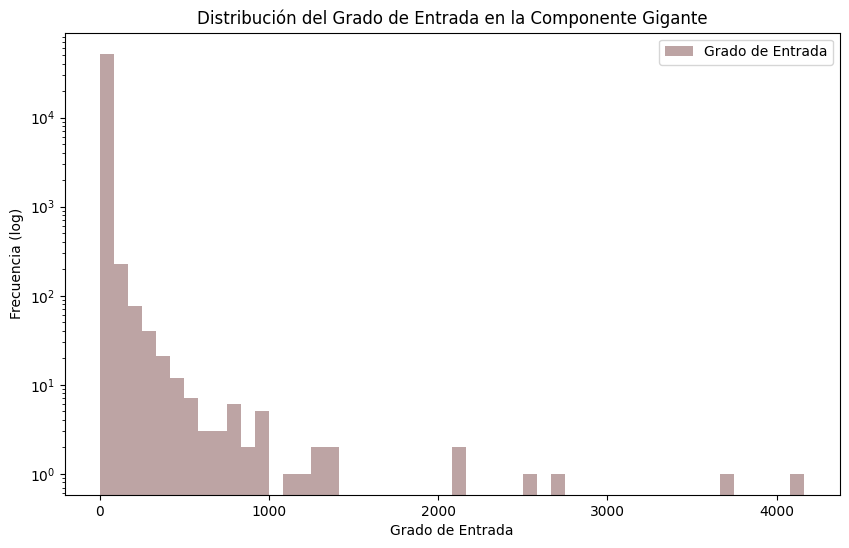

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(in_degree_values_giant, bins=50, log=True, alpha=0.5, color='#7D4A4B', label='Grado de Entrada')  # Usamos escala logarítmica
plt.title('Distribución del Grado de Entrada en la Componente Gigante')
plt.xlabel('Grado de Entrada')
plt.ylabel('Frecuencia (log)')
plt.legend()
plt.savefig('Distribución de grado entrada general gigante.jpg')

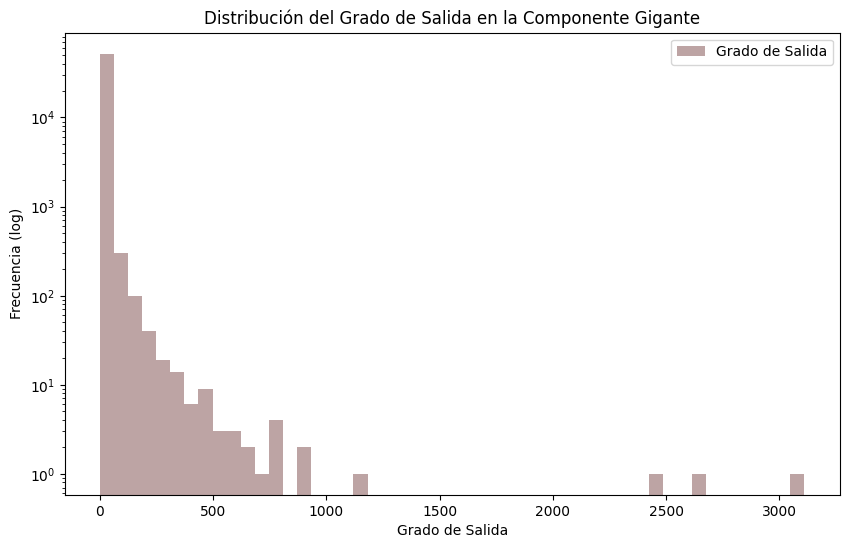

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(out_degree_values_giant, bins=50, log=True, alpha=0.5, color='#7D4A4B', label='Grado de Salida')  # Usamos escala logarítmica
plt.title('Distribución del Grado de Salida en la Componente Gigante')
plt.xlabel('Grado de Salida')
plt.ylabel('Frecuencia (log)')
plt.legend()
plt.savefig('Distribución de grado salida general gigante.jpg')

**Medidas de centralidad**

Centralidad de Grado

In [ ]:
# Calcular centralidad de grado
degree_centrality = nx.degree_centrality(G1)
# Convertir en lista de tuplas (nodo, centralidad) y ordenar
sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)
# Obtener los 50 nodos más influyentes según la centralidad de grado
top_50_nodes_by_degree = sorted_degree_centrality[:50]

# Mostrar los 50 nodos más influyentes con su centralidad de grado
for node, centrality in top_50_nodes_by_degree:
    print(f"Nodo: {node}, Centralidad de Grado: {centrality}")

Nodo: askreddit, Centralidad de Grado: 0.0793641717651095
Nodo: iama, Centralidad de Grado: 0.07063487525492215
Nodo: bestof, Centralidad de Grado: 0.06680389578211067
Nodo: subredditdrama, Centralidad de Grado: 0.06283949911372863
Nodo: funny, Centralidad de Grado: 0.056988202107991694
Nodo: pics, Centralidad de Grado: 0.055444374559246765
Nodo: titlegore, Centralidad de Grado: 0.04745840242438104
Nodo: todayilearned, Centralidad de Grado: 0.04740122362627938
Nodo: videos, Centralidad de Grado: 0.044389806926258414
Nodo: gaming, Centralidad de Grado: 0.03945337069014809
Nodo: the_donald, Centralidad de Grado: 0.030095107400842435
Nodo: worldnews, Centralidad de Grado: 0.029370842624888028
Nodo: news, Centralidad de Grado: 0.028589399050831955
Nodo: wtf, Centralidad de Grado: 0.026988392703985363
Nodo: drama, Centralidad de Grado: 0.026683439114109822
Nodo: conspiracy, Centralidad de Grado: 0.026397545123601502
Nodo: gifs, Centralidad de Grado: 0.025425505555873217
Nodo: bitcoin, Centr

In [ ]:
# Calcular centralidad de grado de entrada
in_degree_centrality = nx.in_degree_centrality(G1)
# Convertir en lista de tuplas (nodo, centralidad) y ordenar por centralidad de grado de entrada
sorted_degree_centrality_in = sorted(in_degree_centrality.items(), key=lambda item: item[1], reverse=True)

# Calcular centralidad de grado de salida
out_degree_centrality = nx.out_degree_centrality(G1)
# Convertir en lista de tuplas (nodo, centralidad) y ordenar por centralidad de grado de salida
sorted_degree_centrality_out = sorted(out_degree_centrality.items(), key=lambda item: item[1], reverse=True)

Centralidad de Intermediación

In [ ]:
# Asumiendo que G es tu grafo dirigido
# k es el número de nodos de origen a utilizar en el cálculo
k = 1000

# Calcular la centralidad de intermediación aproximada
betweenness_centrality_approx = nx.betweenness_centrality(G1, k=k, normalized=True, endpoints=False)

# Ordenar los nodos por su centralidad de intermediación aproximada
sorted_betweenness_approx = sorted(betweenness_centrality_approx.items(), key=lambda item: item[1], reverse=True)

# Obtener los 50 nodos más influyentes según la centralidad de intermediación aproximada
top_50_nodes_by_betweenness_approx = sorted_betweenness_approx[:50]

# Imprimir los 50 nodos más influyentes con su centralidad de intermediación aproximada
for node, centrality in top_50_nodes_by_betweenness_approx:
    print(f"Nodo: {node}, Centralidad de Intermediación Aproximada: {centrality}")

Nodo: bestof, Centralidad de Intermediación Aproximada: 0.03879248096087623
Nodo: subredditdrama, Centralidad de Intermediación Aproximada: 0.038703287211604244
Nodo: gaming, Centralidad de Intermediación Aproximada: 0.0272091348116597
Nodo: funny, Centralidad de Intermediación Aproximada: 0.026940350138836052
Nodo: todayilearned, Centralidad de Intermediación Aproximada: 0.025369460837555712
Nodo: the_donald, Centralidad de Intermediación Aproximada: 0.020168737154161856
Nodo: videos, Centralidad de Intermediación Aproximada: 0.01587567762510938
Nodo: bitcoin, Centralidad de Intermediación Aproximada: 0.014890691625263092
Nodo: conspiracy, Centralidad de Intermediación Aproximada: 0.013271605686136913
Nodo: worldnews, Centralidad de Intermediación Aproximada: 0.012365785810370646
Nodo: pics, Centralidad de Intermediación Aproximada: 0.012158296613305827
Nodo: news, Centralidad de Intermediación Aproximada: 0.01181040634715054
Nodo: iama, Centralidad de Intermediación Aproximada: 0.009

Centralidad de Vector Propio

In [ ]:
# Calcular la centralidad de vector propio (eigenvector centrality)
eigenvector_dict = nx.eigenvector_centrality_numpy(G)

# Ordenar los nodos por su centralidad de vector propio
sorted_eigenvector = sorted(eigenvector_dict.items(), key=lambda item: item[1], reverse=True)

# Obtener los 50 nodos más influyentes
top_50_nodes_by_eigenvector = sorted_eigenvector[:50]

for node, centrality in top_50_nodes_by_eigenvector:
    print(f"Nodo: {node}, Centralidad de Vector Propio: {centrality}")

Nodo: iama, Centralidad de Vector Propio: 0.24569638104455355
Nodo: askreddit, Centralidad de Vector Propio: 0.23730673765789656
Nodo: pics, Centralidad de Vector Propio: 0.20119945444689988
Nodo: funny, Centralidad de Vector Propio: 0.1966055995574634
Nodo: videos, Centralidad de Vector Propio: 0.19293510444419804
Nodo: todayilearned, Centralidad de Vector Propio: 0.17628897880206534
Nodo: worldnews, Centralidad de Vector Propio: 0.14074774582598756
Nodo: gaming, Centralidad de Vector Propio: 0.1388214745786918
Nodo: news, Centralidad de Vector Propio: 0.13771827844820175
Nodo: gifs, Centralidad de Vector Propio: 0.12602668528435054
Nodo: science, Centralidad de Vector Propio: 0.12520913591816069
Nodo: wtf, Centralidad de Vector Propio: 0.1186828910063704
Nodo: the_donald, Centralidad de Vector Propio: 0.11149513624024664
Nodo: showerthoughts, Centralidad de Vector Propio: 0.11058266272872957
Nodo: movies, Centralidad de Vector Propio: 0.1101909460018682
Nodo: technology, Centralidad 

Pasamos de listas de tuplas a diccionarios para cada medida

In [ ]:
degree_centrality_in_dict = dict(sorted_degree_centrality_in)
degree_centrality_out_dict = dict(sorted_degree_centrality_out)
eigenvector_centrality_dict = dict(sorted_eigenvector)
#closeness_centrality_dict = dict(sorted_closeness)
betweenness_centrality_dict = dict(sorted_betweenness_approx)

Extraemos los valores de las medidas de centralidad en listas para facilitar su graficación:

In [ ]:
degree_centrality_in_dict_values = list(degree_centrality_in_dict.values())
degree_centrality_out_dict_values = list(degree_centrality_out_dict.values())
eigenvector_centrality_dict_values = list(eigenvector_centrality_dict.values())
betweenness_centrality_dict_values = list(betweenness_centrality_dict.values())

## Gráficas de las distribuciones - Componente gigante:

Centralidad de grado de entrada:

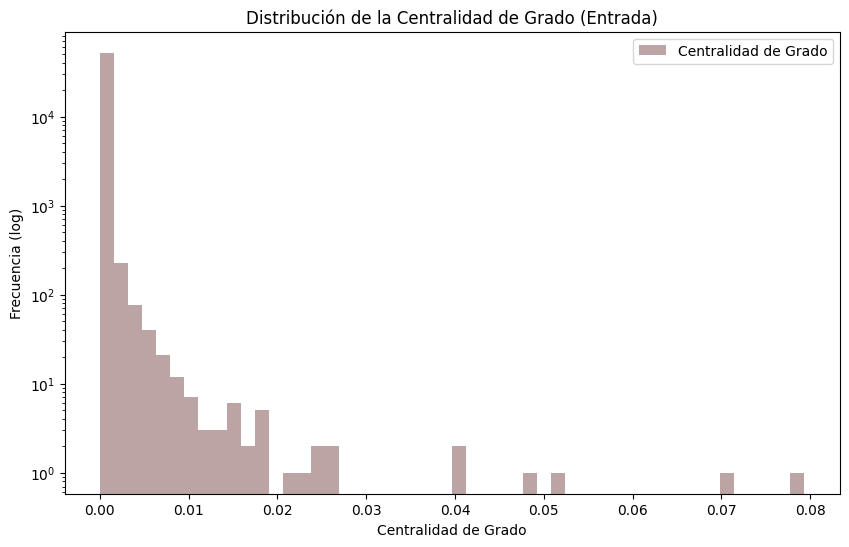

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(degree_centrality_in_dict_values, bins=50, log=True, alpha=0.5, color='#7D4A4B', label='Centralidad de Grado')  # Usamos escala logarítmica
plt.title('Distribución de la Centralidad de Grado (Entrada)')
plt.xlabel('Centralidad de Grado')
plt.ylabel('Frecuencia (log)')
plt.legend()
plt.savefig('Distribucion centralidad grado entrada general.jpg')

Centralidad de grado de salida:

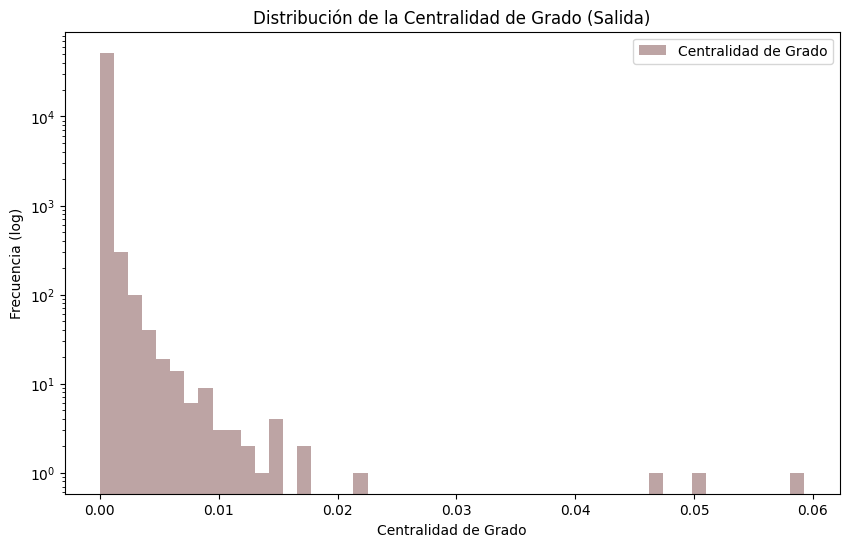

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(degree_centrality_out_dict_values, bins=50, log=True, alpha=0.5, color='#7D4A4B', label='Centralidad de Grado')  # Usamos escala logarítmica
plt.title('Distribución de la Centralidad de Grado (Salida)')
plt.xlabel('Centralidad de Grado')
plt.ylabel('Frecuencia (log)')
plt.legend()
plt.savefig('Distribucion centralidad grado salida general.jpg')

Centralidad de vector propio:

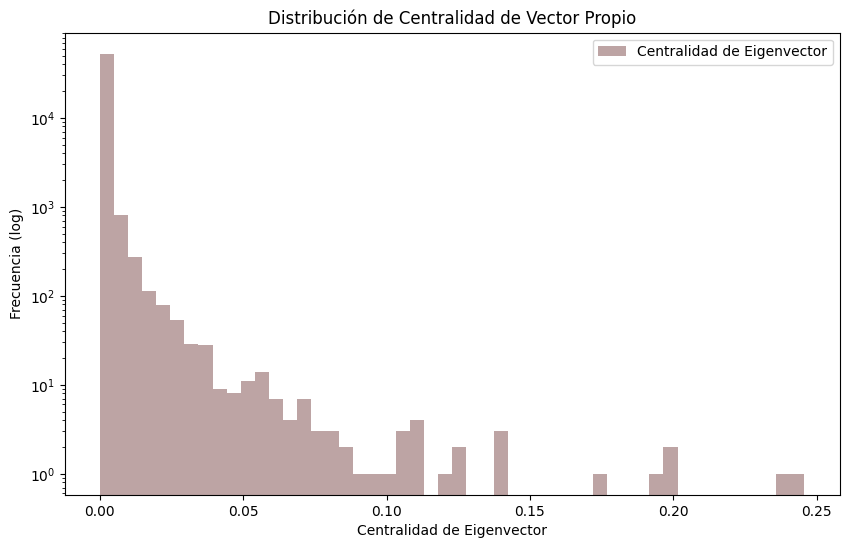

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(eigenvector_centrality_dict_values, bins=50, log=True, alpha=0.5, color='#7D4A4B', label='Centralidad de Eigenvector')  # Usamos escala logarítmica
plt.title('Distribución de Centralidad de Vector Propio')
plt.xlabel('Centralidad de Eigenvector')
plt.ylabel('Frecuencia (log)')
plt.legend()
plt.savefig('Distribucion centralidad eigenvector general.jpg')

Centralidad de intermediación:

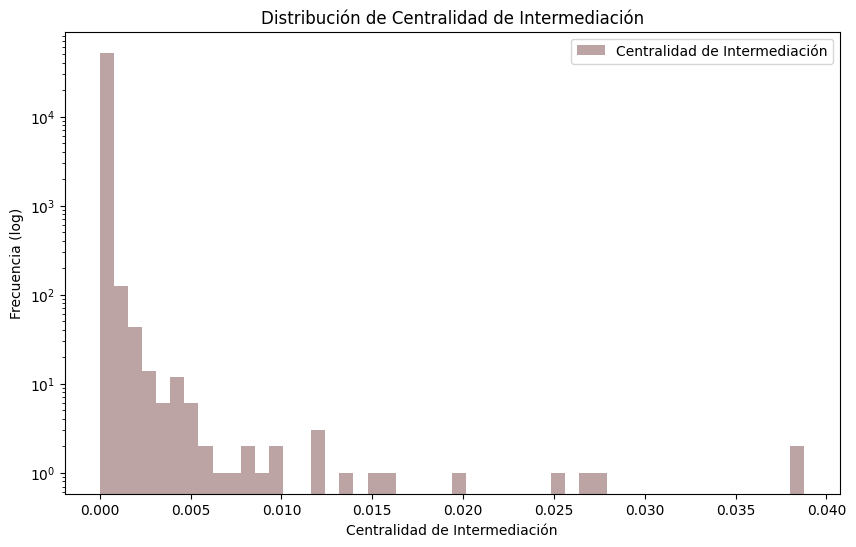

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(betweenness_centrality_dict_values, bins=50, log=True, alpha=0.5, color='#7D4A4B', label='Centralidad de Intermediación')  # Usamos escala logarítmica
plt.title('Distribución de Centralidad de Intermediación')
plt.xlabel('Centralidad de Intermediación')
plt.ylabel('Frecuencia (log)')
plt.legend()
plt.savefig('Distribucion centralidad intermediacion general.jpg')

Estadísticas Descriptivas

In [ ]:
# Convertir los diccionarios en un DataFrame de pandas para facilitar el análisis
centrality_df = pd.DataFrame({
    'Grado Entrada': pd.Series(degree_centrality_in_dict),
    'Grado Salida': pd.Series(degree_centrality_out_dict),
    'Vector Propio': pd.Series(eigenvector_centrality_dict),
    #'closeness': pd.Series(closeness_centrality_dict),
    'Intermediacion': pd.Series(betweenness_centrality_dict)
})

In [ ]:
descriptive_stats = centrality_df.describe()
print(descriptive_stats)
descriptive_stats.to_excel('Estadísticas Descriptivas General.xlsx')

       Grado Entrada  Grado Salida  Vector Propio  Intermediacion
count   52468.000000  52468.000000   5.407500e+04    52468.000000
mean        0.000085      0.000085   6.734785e-04        0.000021
std         0.000812      0.000559   4.247304e-03        0.000394
min         0.000000      0.000000  -9.142152e-19        0.000000
25%         0.000000      0.000019  -1.822269e-22        0.000000
50%         0.000000      0.000019   4.544195e-21        0.000000
75%         0.000038      0.000038   1.497601e-04        0.000000
max         0.079364      0.059294   2.456964e-01        0.038792


El 75% de los nodos (percentil 25% al 75%) tienen centralidades extremadamente bajas, casi iguales a los mínimos, lo que refuerza la idea de una red con muchos nodos de poca importancia.

Los valores máximos (max) son mucho mayores que los percentiles 75%, destacando la presencia de unos pocos nodos altamente centrales o influyentes. Esto es particularmente notorio en la centralidad de eigenvector y betweenness.

Correlación entre las medidas de centralidad

In [ ]:
correlation_matrix = centrality_df.corr()
print(correlation_matrix)
correlation_matrix.to_excel('Correlaciones Medidad Centralidad General.xlsx')

                Grado Entrada  Grado Salida  Vector Propio  Intermediacion
Grado Entrada        1.000000      0.291486       0.924830        0.603029
Grado Salida         0.291486      1.000000       0.359645        0.683008
Vector Propio        0.924830      0.359645       1.000000        0.606559
Intermediacion       0.603029      0.683008       0.606559        1.000000


 Alta Correlación entre Grado y Eigenvector (0.856120):
los nodos con muchos enlaces (alto grado) tienden también a estar conectados con otros nodos bien conectados (alta centralidad de eigenvector). En términos prácticos, significa que los subreddits que tienen muchos otros subreddits enlazándolos (o a los que enlazan) también suelen estar en una posición central dentro de los grupos o comunidades más importantes de la red.

Correlación Moderada-Alta entre Grado y Betweenness (0.777703):
Los nodos con alta centralidad de grado también tienden a tener una alta centralidad de intermediación, pero la relación no es tan fuerte como con la centralidad de eigenvector. Esto sugiere que, aunque los nodos con muchos enlaces directos frecuentemente actúan como puentes importantes en la red (facilitando el flujo de información), la capacidad de actuar como intermediario no depende únicamente del número de conexiones.

Correlación Moderada entre Eigenvector y Betweenness (0.592318):
Esta correlación más baja indica que la importancia de un nodo como punto central dentro de su comunidad (alta centralidad de eigenvector) no siempre se traduce en actuar como un puente clave entre comunidades (alta centralidad de betweenness). Hay nodos que, a pesar de estar bien conectados dentro de sus propios grupos, no necesariamente conectan diferentes partes de la red.

# Análisis de Subgrupos de Interés

Política

In [ ]:
subreddits_politicos = [
    'politics', 'government', 'political', 'policy', 'governance', 'state', 'law', 'legislation',
    'congress', 'parliament', 'democracy', 'authoritarian', 'regime', 'electoral', 'election',
    'conservative', 'liberal', 'socialism', 'libertarian', 'communist', 'anarchism', 'progressive',
    'rightwing', 'leftwing', 'centrist', 'greenpolitics', 'feminism', 'republican', 'democrat',
    'gop', 'labour', 'tory', 'greens', 'teaParty', 'occupy', 'blacklivesmatter', 'antifa',
    'brexit', 'impeachment', 'referendum', 'climatechange', 'guncontrol',
    'healthcare', 'immigration', 'uspolitics', 'ukpolitics', 'europarl', 'middleeast', 'russia',
    'china', 'venezuela', 'syria', 'Israel', 'Palestine', 'war',
    #Añadiendo palabras relacionadas con Colombia y el capitalismo
    'colombia', 'colombian', 'farc', 'eln', 'peaceprocess', 'bogota', 'medellin',
    'capitalism', 'anticapitalism', 'neoliberalism', 'marxism', 'freeMarket', 'protest', 'strike',
    'paramilitary','guerilla','peaceagreement','privatization','tradeagreements', 'cali','humanrights',
    'latam', 'populism','debtcrisis', 'femicide','genderEquality','socialJustice','agrarianReform',
    'indigenousRights','patriarchy','machismo','economicReform','ruralDevelopment','socialMovements',
    'TLC','freeTrade','capitalismvsocialism','colombiapolitics', 'sudamerica','latinamericanpolitics',
    'leftvsright',
    #Ahora en español
    'politica','gobierno','politico','politicas','gobernanza','estado','ley','legislacion','congreso',
    'parlamento','democracia','autoritario','regimen','electoral','eleccion','conservador','liberal',
    'socialismo','libertario','comunista','anarquismo','progresista','derecha','izquierda','centrista',
    'politicaVerde','feminismo','republicano','democrata','GOP','laborista','conservadorReinoUnido',
    'verdes','TeaParty','ocupar','lasVidasNegrasImportan','antifa','eleccion','brexit','juicioPolitico',
    'referendum','cambioClimatico','controlDeArmas','atencionMedica','inmigracion','politicaEEUU',
    'politicaReinoUnido','parlamentoEuropeo','MedioOriente','Rusia','China','Venezuela','Siria','Israel',
    'Palestina','guerra',
    'Colombia','colombiano','FARC','ELN','procesoDePaz','Bogota','Medellin','capitalismo',
    'anticapitalismo','neoliberalismo','marxismo','libreMercado','protesta','huelga','paramilitar',
    'guerrilla','acuerdoDePaz','privatizacion','acuerdosComerciales','Cali','derechosHumanos',
    'AmericaLatina','populismo','crisisDeDeuda','feminicidio','igualdadDeGenero','justiciaSocial',
    'reformaAgraria','derechosIndigenas','patriarcado','machismo','reformaEconomica','desarrolloRural',
    'movimientosSociales','tratadoDeLibreComercio','libreComercio','capitalismovsSocialismo',
    'politicaColombiana','Sudamerica','politicaLatinoamericana','izquierdavsderecha'
]

In [ ]:
#Crear un subgrafo con solo los nodos de interés (que contienen las palabras clave)
subgraph_political = G.subgraph([node for node in G.nodes() if any(keyword in node.lower() for keyword in subreddits_politicos)])

len(subgraph_political)

1881

In [ ]:
densidad_sub = nx.density(subgraph_political)
print(f"Densidad del subgrafo: {densidad_sub}")

Densidad del subgrafo: 0.00048355899419729207


Medidas de centralidad

In [ ]:
# Centralidad de grado de entrada
degree_centrality_in = nx.in_degree_centrality(subgraph_political)
sorted_degree_centrality_in = sorted(degree_centrality_in.items(), key=lambda item: item[1], reverse=True)

# Centralidad de grado de salida
degree_centrality_out = nx.out_degree_centrality(subgraph_political)
sorted_degree_centrality_out = sorted(degree_centrality_out.items(), key=lambda item: item[1], reverse=True)


# Centralidad de vector propio (eigenvector)
eigenvector_centrality = nx.eigenvector_centrality_numpy(subgraph_political)
sorted_eigenvector = sorted(eigenvector_centrality.items(), key=lambda item: item[1], reverse=True)

# Centralidad de cercanía
closeness_centrality = nx.closeness_centrality(subgraph_political)
sorted_closeness = sorted(closeness_centrality.items(), key=lambda item: item[1], reverse=True)

# Centralidad de betweenness (aproximada)
k = 200
betweenness_centrality = nx.betweenness_centrality(subgraph_political, k=k, normalized=True, endpoints=False)
sorted_betweenness_approx = sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True)


Pasamos los valores de centralidad calculados a diccionarios, los cuales posteriormente pasaremos a listas para poder graficar:

In [ ]:
degree_centrality_in_dict = dict(sorted_degree_centrality_in)
degree_centrality_out_dict = dict(sorted_degree_centrality_out)
eigenvector_centrality_dict = dict(sorted_eigenvector)
closeness_centrality_dict = dict(sorted_closeness)
betweenness_centrality_dict = dict(sorted_betweenness_approx)

In [ ]:
degree_centrality_in_dict_values = list(degree_centrality_in_dict.values())
degree_centrality_out_dict_values = list(degree_centrality_out_dict.values())
eigenvector_centrality_dict_values = list(eigenvector_centrality_dict.values())
closeness_centrality_dict_values = list(closeness_centrality_dict.values())
betweenness_centrality_dict_values = list(betweenness_centrality_dict.values())

##Gráficas de las distribuciones - Subgrafo Político##

Centralidad de grado de entrada:

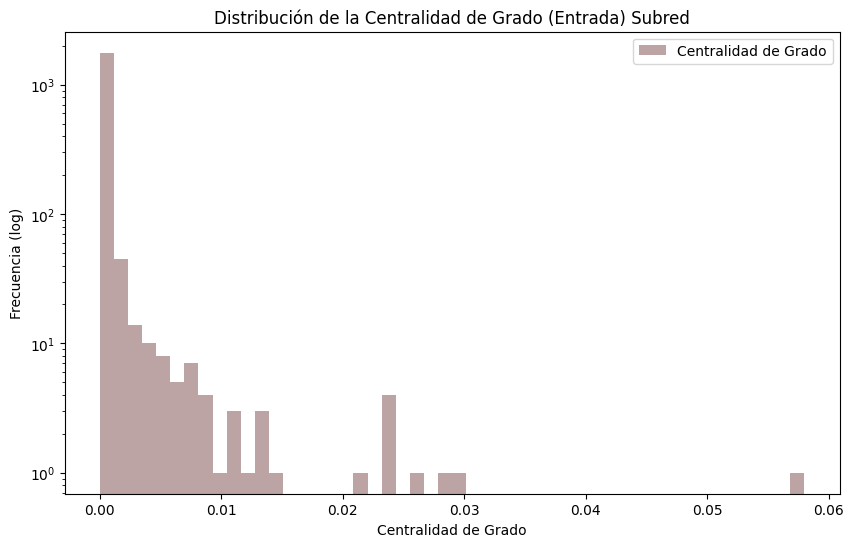

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(degree_centrality_in_dict_values, bins=50, log=True, alpha=0.5, color='#7D4A4B', label='Centralidad de Grado')  # Usamos escala logarítmica
plt.title('Distribución de la Centralidad de Grado (Entrada) Subred')
plt.xlabel('Centralidad de Grado')
plt.ylabel('Frecuencia (log)')
plt.legend()
plt.savefig('Distribucion centralidad grado entrada subred.jpg')

Centralidad de grado de salida:

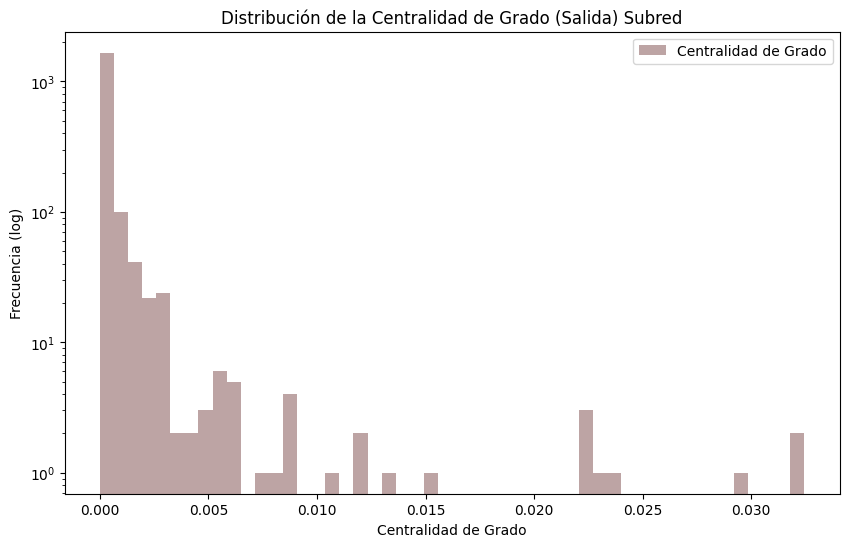

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(degree_centrality_out_dict_values, bins=50, log=True, alpha=0.5, color='#7D4A4B', label='Centralidad de Grado')  # Usamos escala logarítmica
plt.title('Distribución de la Centralidad de Grado (Salida) Subred')
plt.xlabel('Centralidad de Grado')
plt.ylabel('Frecuencia (log)')
plt.legend()
plt.savefig('Distribucion centralidad grado salida subred.jpg')

Centralidad de vector propio:

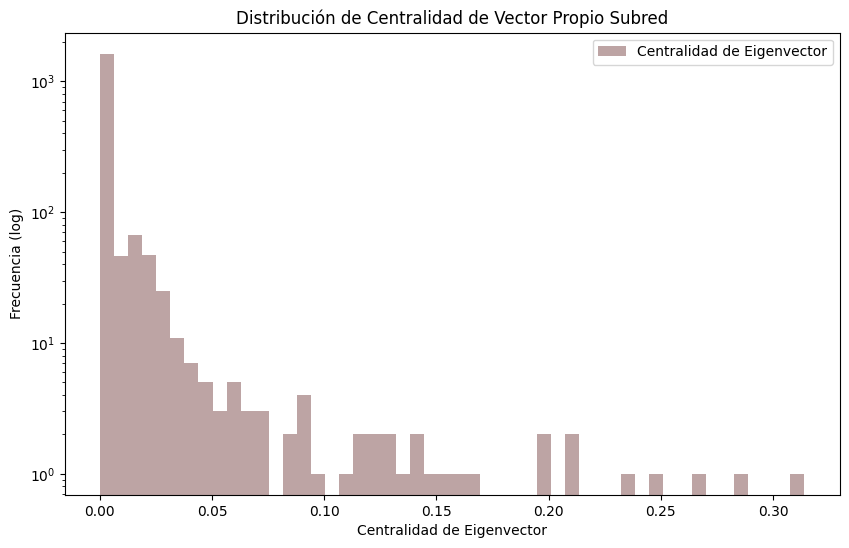

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(eigenvector_centrality_dict_values, bins=50, log=True, alpha=0.5, color='#7D4A4B', label='Centralidad de Eigenvector')  # Usamos escala logarítmica
plt.title('Distribución de Centralidad de Vector Propio Subred')
plt.xlabel('Centralidad de Eigenvector')
plt.ylabel('Frecuencia (log)')
plt.legend()
plt.savefig('Distribucion centralidad eigenvector subred.jpg')

Centralidad de cercanía:

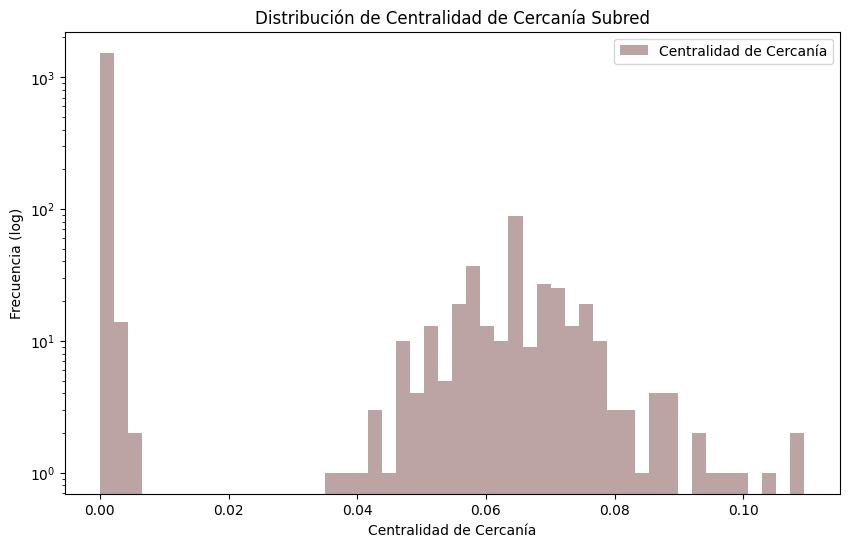

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(closeness_centrality_dict_values, bins=50, log=True, alpha=0.5, color='#7D4A4B', label='Centralidad de Cercanía')  # Usamos escala logarítmica
plt.title('Distribución de Centralidad de Cercanía Subred')
plt.xlabel('Centralidad de Cercanía')
plt.ylabel('Frecuencia (log)')
plt.legend()
plt.savefig('Distribucion centralidad cercania subred.jpg')

Centralidad de intermediación:

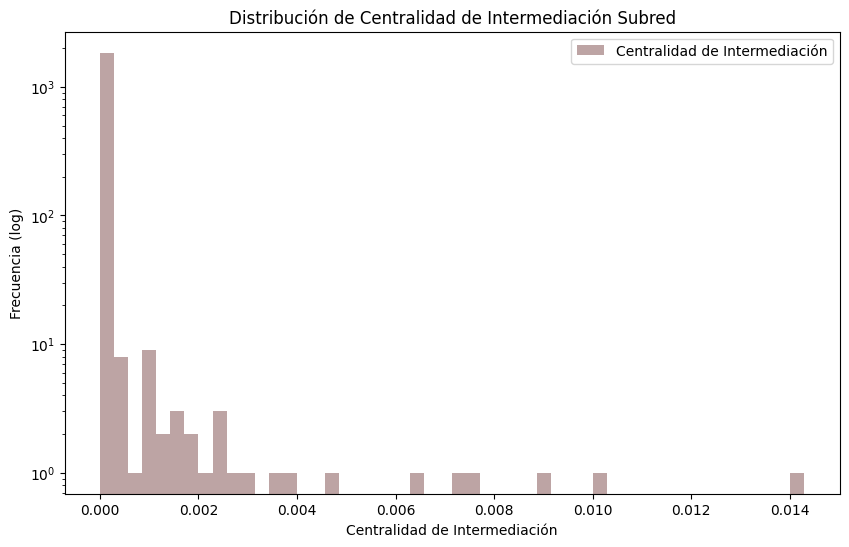

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(betweenness_centrality_dict_values, bins=50, log=True, alpha=0.5, color='#7D4A4B', label='Centralidad de Intermediación')  # Usamos escala logarítmica
plt.title('Distribución de Centralidad de Intermediación Subred')
plt.xlabel('Centralidad de Intermediación')
plt.ylabel('Frecuencia (log)')
plt.legend()
plt.savefig('Distribucion centralidad intermediacion subred.jpg')

Estadísticas descriptivas:

In [ ]:
# Convertir los diccionarios en un DataFrame de pandas para facilitar el análisis
centrality_subgraph_df = pd.DataFrame({
    'Grado Entrada': pd.Series(degree_centrality_in),
    'Grado Salida': pd.Series(degree_centrality_out),
    'Vector Propio': pd.Series(eigenvector_centrality),
    'Cercania': pd.Series(closeness_centrality),
    'Intermediacion': pd.Series(betweenness_centrality)
})

In [ ]:
descriptive_stats = centrality_subgraph_df.describe()
print(descriptive_stats)
descriptive_stats.to_excel('Estadísticas Descriptivas Subred.xlsx')


       Grado Entrada  Grado Salida  Vector Propio     Cercania  Intermediacion
count    1881.000000   1881.000000   1.881000e+03  1881.000000     1881.000000
mean        0.000484      0.000484   5.217479e-03     0.011597        0.000060
std         0.002430      0.001996   2.246505e-02     0.025283        0.000591
min         0.000000      0.000000  -8.050641e-18     0.000000        0.000000
25%         0.000000      0.000000  -3.544712e-20     0.000000        0.000000
50%         0.000000      0.000000   1.281192e-20     0.000000        0.000000
75%         0.000000      0.000532   1.669970e-19     0.000000        0.000000
max         0.057979      0.032447   3.139217e-01     0.109483        0.014295


In [ ]:
correlation_matrix = centrality_subgraph_df.corr()
print(correlation_matrix)
correlation_matrix.to_excel('Correlaciones Medidas Centralidad subred.xlsx')

                Grado Entrada  Grado Salida  Vector Propio  Cercania  \
Grado Entrada        1.000000      0.686514       0.913376  0.483818   
Grado Salida         0.686514      1.000000       0.693315  0.395150   
Vector Propio        0.913376      0.693315       1.000000  0.617080   
Cercania             0.483818      0.395150       0.617080  1.000000   
Intermediacion       0.887465      0.696587       0.754576  0.309627   

                Intermediacion  
Grado Entrada         0.887465  
Grado Salida          0.696587  
Vector Propio         0.754576  
Cercania              0.309627  
Intermediacion        1.000000  


In [ ]:
# Calcular las medias de las centralidades
avg_degree_centrality = sum(degree_centrality.values()) / len(degree_centrality)
avg_eigenvector_centrality = sum(eigenvector_centrality.values()) / len(eigenvector_centrality)
avg_closeness_centrality = sum(closeness_centrality.values()) / len(closeness_centrality)
avg_betweenness_centrality = sum(betweenness_centrality.values()) / len(betweenness_centrality)

# Imprimir las medias de las centralidades
print(f"Centralidad de Grado Promedio: {avg_degree_centrality}")
print(f"Centralidad de Vector Propio Promedio: {avg_eigenvector_centrality}")
print(f"Centralidad de Cercanía Promedio: {avg_closeness_centrality}")
print(f"Centralidad de Betweenness Promedio: {avg_betweenness_centrality}")

Centralidad de Grado Promedio: 0.00016994022369392757
Centralidad de Vector Propio Promedio: 0.005217478946582444
Centralidad de Cercanía Promedio: 0.011597306614171979
Centralidad de Betweenness Promedio: 6.746033992730399e-05


In [ ]:
# Función para imprimir los top N nodos más influyentes según una medida de centralidad
def print_top_n_nodes(centrality_dict, n=20, centrality_name="Centralidad"):
    sorted_nodes = sorted(centrality_dict.items(), key=lambda item: item[1], reverse=True)[:n]
    print(f"Top {n} nodos por {centrality_name}:")
    for i, (node, centrality_value) in enumerate(sorted_nodes, 1):
        print(f"{i}. Nodo: {node}, {centrality_name}: {centrality_value}")
    print("\n")  # Añadir una línea en blanco para separar las listas

# Imprimir los 20 nodos más influyentes según la centralidad de grado
print_top_n_nodes(degree_centrality, 40, "Centralidad de Grado")

# Imprimir los 20 nodos más influyentes según la centralidad de vector propio
print_top_n_nodes(eigenvector_centrality, 40, "Centralidad de Vector Propio")

# Imprimir los 20 nodos más influyentes según la centralidad de cercanía
print_top_n_nodes(closeness_centrality, 40, "Centralidad de Cercanía")

# Imprimir los 20 nodos más influyentes según la centralidad de betweenness
print_top_n_nodes(betweenness_centrality, 40, "Centralidad de Betweenness")

Top 40 nodos por Centralidad de Grado:
1. Nodo: askreddit, Centralidad de Grado: 0.0793641717651095
2. Nodo: iama, Centralidad de Grado: 0.07063487525492215
3. Nodo: bestof, Centralidad de Grado: 0.06680389578211067
4. Nodo: subredditdrama, Centralidad de Grado: 0.06283949911372863
5. Nodo: funny, Centralidad de Grado: 0.056988202107991694
6. Nodo: pics, Centralidad de Grado: 0.055444374559246765
7. Nodo: titlegore, Centralidad de Grado: 0.04745840242438104
8. Nodo: todayilearned, Centralidad de Grado: 0.04740122362627938
9. Nodo: videos, Centralidad de Grado: 0.044389806926258414
10. Nodo: gaming, Centralidad de Grado: 0.03945337069014809
11. Nodo: the_donald, Centralidad de Grado: 0.030095107400842435
12. Nodo: worldnews, Centralidad de Grado: 0.029370842624888028
13. Nodo: news, Centralidad de Grado: 0.028589399050831955
14. Nodo: wtf, Centralidad de Grado: 0.026988392703985363
15. Nodo: drama, Centralidad de Grado: 0.026683439114109822
16. Nodo: conspiracy, Centralidad de Grado: 0.

In [ ]:
# Función para convertir todos los atributos a string
def convert_attributes_to_string(G):
    for node, attrs in G.nodes(data=True):
        for attr, value in attrs.items():
            # Convertir el valor del atributo a string
            G.nodes[node][attr] = str(value)
    for source, target, attrs in G.edges(data=True):
        for attr, value in attrs.items():
            # Convertir el valor del atributo a string
            G[source][target][attr] = str(value)

# Copia del subgrafo para no modificar el original
subgraph_political_copy = subgraph_political.copy()

# Convertir todos los atributos del subgrafo a string
convert_attributes_to_string(subgraph_political_copy)

# Ruta de acceso para guardar el archivo
output_file_path = '/content/drive/MyDrive/Inv. teórica/Base de Datos/subgraph_political.gexf'

# Guardar el grafo en formato GEXF
nx.write_gexf(subgraph_political_copy, output_file_path)

Componente gigante del subgrafo

In [ ]:
# Encontrar las componentes conectadas (si el grafo es no dirigido) o fuertemente conectadas (si es dirigido)
connected_components = list(nx.strongly_connected_components(subgraph_political))

# Encontrar la componente gigante (la de mayor tamaño)
giant_component = max(connected_components, key=len)

# Crear un subgrafo a partir de la componente gigante
subgraph_political_giant = subgraph_political.subgraph(giant_component).copy()

# Imprimir el número de nodos en la componente gigante
print(f"El número de nodos en la componente gigante es: {subgraph_political_giant.number_of_nodes()}")


In [ ]:
# Crear una copia de subgraph_political_giant con los atributos de tipo lista convertidos a cadenas
subgraph_political_giant_copy = subgraph_political_giant.copy()

for u, v, data in subgraph_political_giant_copy.edges(data=True):
    # Convertir 'post_properties' de lista a cadena de texto si es una lista
    if isinstance(data.get('post_properties'), list):
        data['post_properties'] = ','.join(map(str, data['post_properties']))

# Guardar el subgrafo subgraph_political_giant_copy en un archivo GraphML
nx.write_graphml(subgraph_political_giant_copy, '/content/drive/MyDrive/Inv. teórica/Base de Datos/subgraph_political_giant.graphml')


##Top nodos con sentimiento negativo

In [ ]:
# Asignar el atributo 'post_label' al nodo de salida de cada arista
for u, v, data in subgraph_political.edges(data=True):
    # Verificamos si la arista tiene el atributo 'post_label'
    post_label = data.get('post_label')

    if post_label is not None:
        # Asignamos el valor de 'post_label' al nodo de salida (source)
        subgraph_political.nodes[u]['post_label'] = post_label
        print(f"Nodo {u} asignado con post_label: {post_label}")


In [ ]:
import networkx as nx

# Calcular la centralidad de grado para todos los nodos en el subgrafo político
degree_centrality = nx.degree_centrality(subgraph_political)

# Filtrar los nodos que tienen un 'post_label' de -1
nodes_with_negative_post_label = [node for node, data in subgraph_political.nodes(data=True) if data.get('post_label') == -1]

# Filtrar los nodos que tienen un 'post_label' de -1 y calcular su centralidad de grado
degree_centrality_filtered = {node: degree_centrality[node] for node in nodes_with_negative_post_label}

# Ordenar los nodos por centralidad de grado de mayor a menor
sorted_nodes = sorted(degree_centrality_filtered.items(), key=lambda x: x[1], reverse=True)

# Obtener los 55 nodos más centrales
top_45_nodes = sorted_nodes[:55]

# Mostrar los nodos seleccionados
print("Top 45 nodos con mayor centralidad de grado y 'post_label = -1':")
for node, centrality in top_45_nodes:
    print(f"Node: {node}, Degree Centrality: {centrality}")


## Modelo de Threshold

In [ ]:
# Asignamos un umbral por defecto para todos los nodos si no lo tienen definido
default_threshold = 0.5
for node in G1.nodes():
    if node not in thresholds:
        thresholds[node] = default_threshold

# Función corregida para manejar divisiones por cero
def threshold_diffusion(G, initial_nodes, thresholds):
    adopted = set(initial_nodes)  # Nodos que ya adoptaron la ideología
    newly_adopted = set(initial_nodes)

    while newly_adopted:
        next_adopted = set()

        # Recorremos todos los nodos que aún no han adoptado
        for node in set(G.nodes()) - adopted:
            predecessors = list(G.predecessors(node))  # Vecinos que apuntan a este nodo
            if len(predecessors) == 0:
                continue  # Si no tiene vecinos que lo influencien, omitimos este nodo

            # Contar cuántos de sus vecinos ya adoptaron la ideología
            active_neighbors = sum(1 for neighbor in predecessors if neighbor in adopted)

            # Si la proporción de vecinos adoptados supera el umbral, el nodo también adopta la ideología
            if active_neighbors / len(predecessors) > thresholds[node]:
                next_adopted.add(node)

        newly_adopted = next_adopted
        adopted.update(newly_adopted)

    return adopted

# Nodos iniciales que empiezan con la ideología (por ejemplo, los 45 nodos encontrados antes)
initial_nodes = top_45_node_names

# Correr el modelo de difusión basado en threshold en G1 (la componente gigante)
adopted_nodes = threshold_diffusion(G1, initial_nodes, thresholds)

print(f"Nodos que adoptaron la ideología: {len(adopted_nodes)}")


In [ ]:
len(G1)